# Proyecto 2- Cruz Cortés Diego
## Diplomado Ciencia de Datos

## [Malaria Project](https://lhncbc.nlm.nih.gov/LHC-research/LHC-projects/image-processing/malaria-project.html)

De aquí saqué toda la información recabada respecto al dataset, se cataloga en 2 grupos, infectados y no infectados.

In [2]:
!pip install -q kaggle
import os
import zipfile

# Crear el directorio .kaggle y mover kaggle.json allí
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
# conjunto de datos
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

# Descompresion del archivo descargado
with zipfile.ZipFile('cell-images-for-detecting-malaria.zip', 'r') as zip_ref:
    zip_ref.extractall('malaria_dataset')


Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown


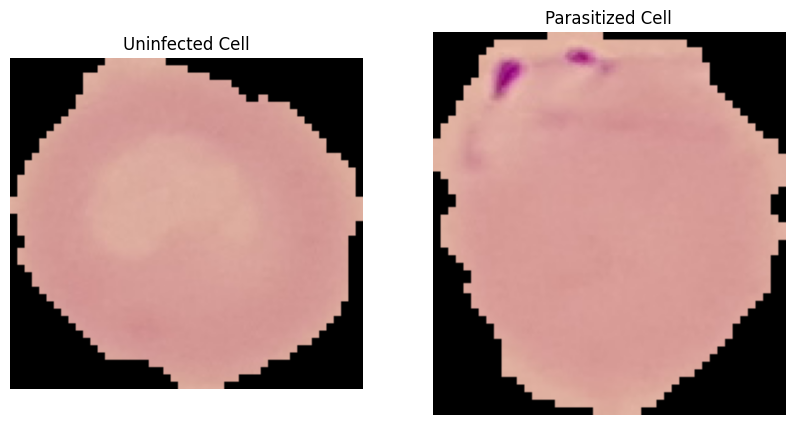

In [4]:
import cv2
import matplotlib.pyplot as plt

# Rutas a imágenes de ejemplo
uninfected_path = 'malaria_dataset/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_131.png'
parasitized_path = 'malaria_dataset/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_164.png'

# Leer las imágenes
uninfected_img = cv2.imread(uninfected_path)
parasitized_img = cv2.imread(parasitized_path)

# Convertir de BGR a RGB para visualización
uninfected_img = cv2.cvtColor(uninfected_img, cv2.COLOR_BGR2RGB)
parasitized_img = cv2.cvtColor(parasitized_img, cv2.COLOR_BGR2RGB)

# Mostrar las imágenes
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(uninfected_img)
plt.title('Uninfected Cell')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(parasitized_img)
plt.title('Parasitized Cell')
plt.axis('off')

plt.show()


In [8]:
import cv2
import numpy as np
import torch

def apply_filters_and_convolutions(img_tensor):
    """
    img_tensor: torch.Tensor C×H×W con valores en [0,1].
    Devuelve: tensor con 1 canal (grayscale), 1 canal (blur), 3 canales (sobel), 1 canal (conv).
    """
    # 1) Grayscale
    img_np = img_tensor.permute(1,2,0).numpy()              # H×W×C
    gray = cv2.cvtColor((img_np*255).astype('uint8'),
                        cv2.COLOR_RGB2GRAY)                # :contentReference[oaicite:2]{index=2}

    # 2) Gaussian Blur
    blur = cv2.GaussianBlur(gray, (5,5), 0)                # :contentReference[oaicite:3]{index=3}

    # 3) Sobel ∂/∂x, ∂/∂y → magnitud
    sobel_x = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=3)   #
    sobel_y = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=3)   #
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel = (sobel / sobel.max()).astype('float32')
    sobel_3c = np.stack([sobel,sobel,sobel], axis=0)       # 3×H×W

    # 4) Convolución personalizada (realce de bordes)
    kernel = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]], dtype=np.float32)
    conv = cv2.filter2D(blur, -1, kernel)                  # :contentReference[oaicite:4]{index=4}

    # Convertir todo de nuevo a tensores
    t_gray = torch.from_numpy(gray.astype('float32')/255).unsqueeze(0)
    t_blur = torch.from_numpy(blur.astype('float32')/255).unsqueeze(0)
    t_sobel = torch.from_numpy(sobel_3c)
    t_conv  = torch.from_numpy(conv.astype('float32')/255).unsqueeze(0)

    # Concatenamos canales si quieres un solo tensor de 5 canales:
    # return torch.cat([t_gray, t_blur, t_sobel, t_conv], dim=0)
    # O bien devolvemos por separado:
    return t_gray, t_blur, t_sobel, t_conv


In [9]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class FilteredMalariaDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        # Listado de rutas a imágenes
        self.img_paths = [os.path.join(img_dir, f)
                          for f in os.listdir(img_dir)
                          if f.endswith('.png')]
        # Etiqueta 0 = Uninfected, 1 = Parasitized
        self.labels = [0 if 'Uninfected' in img_dir else 1] * len(self.img_paths)
        # Transform básico: PIL → Tensor [0,1]
        self.basic_tf = transforms.Compose([
            transforms.Resize((64,64)),      # ajustar tamaño
            transforms.ToTensor()            # :contentReference[oaicite:5]{index=5}
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        path = self.img_paths[idx]
        label = self.labels[idx]
        # Cargar y transformar a tensor
        img = Image.open(path).convert('RGB')
        t = self.basic_tf(img)
        # Aplicar filtros/convoluciones
        t_gray, t_blur, t_sobel, t_conv = apply_filters_and_convolutions(t)
        # Por ejemplo, concatenar todos los canales:
        # salida = torch.cat([t, t_gray, t_blur, t_sobel, t_conv], dim=0)
        # O devolver tuple (X, label)
        return t_sobel, label   # usar solo Sobel como canal de entrada


In [10]:
from torch.utils.data import DataLoader

# Directorios tras descomprimir via Kaggle API:
train_un = 'malaria_dataset/cell_images/Uninfected'
train_pa = 'malaria_dataset/cell_images/Parasitized'

# Instanciamos dos datasets y los combinamos
ds_tr_u = FilteredMalariaDataset(train_un)
ds_tr_p = FilteredMalariaDataset(train_pa)
# Unimos listas
ds_train = ds_tr_u + ds_tr_p        # soportado por Dataset de PyTorch :contentReference[oaicite:7]{index=7}

train_loader = DataLoader(ds_train, batch_size=32, shuffle=True)  # :contentReference[oaicite:8]{index=8}


In [20]:
from PIL import UnidentifiedImageError

def __getitem__(self, idx):
    path = self.img_paths[idx]
    try:
        img = Image.open(path).convert('RGB')
    except UnidentifiedImageError:
        # Simplemente devolvemos la siguiente muestra válida
        return self.__getitem__((idx+1) % len(self))
    # … resto del código …


In [12]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32 * 16 * 16, num_classes)  # Assuming input size 64x64

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)  # Flatten
        x = self.fc(x)
        return x

In [13]:
import torch

def train_and_eval(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
    """
    Trains and evaluates the model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluation loop (assuming you have a test_loader)
        model.eval()
        with torch.no_grad():
            total = 0
            correct = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.2f}%")

    return accuracy

In [15]:
class FilteredMalariaDataset(Dataset):
    def __init__(self, img_dir):
        # Filter out non-image files like Thumbs.db
        self.paths = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.labels = [0 if 'Uninfected' in img_dir else 1] * len(self.paths)
        self.tf = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert('RGB')
        t = self.tf(img)
        sob = apply_filters_and_convolutions(t)
        return sob, self.labels[i]

In [16]:
#–– 1) Definición de la red (evita NameError)
import torch, torch.nn.functional as F
from torch import nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32,64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.fc1   = nn.Linear(64*16*16,128)
        self.fc2   = nn.Linear(128,num_classes)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,64*16*16)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

#–– 2) Dataset y filtros
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2, numpy as np

def apply_filters_and_convolutions(img_tensor):
    # Grayscale
    img_np = img_tensor.permute(1,2,0).numpy()
    gray = cv2.cvtColor((img_np*255).astype('uint8'),
                        cv2.COLOR_RGB2GRAY)           # :contentReference[oaicite:0]{index=0}
    # Gaussian Blur
    blur = cv2.GaussianBlur(gray, (5,5), 0)              #
    # Sobel
    sx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=3)
    sy = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=3)
    mag = np.sqrt(sx**2 + sy**2)
    mag = (mag/mag.max()).astype('float32')
    sobel_3c = np.stack([mag,mag,mag],0)
    # Custom convolution
    kernel = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]],dtype='float32')
    conv = cv2.filter2D(blur, -1, kernel)                #

    # Tensores finales
    t_sobel = torch.from_numpy(sobel_3c)
    return t_sobel

class FilteredMalariaDataset(Dataset):
    def __init__(self, img_dir):
        self.paths = [os.path.join(img_dir,f) for f in os.listdir(img_dir)]
        self.labels = [0 if 'Uninfected' in img_dir else 1]*len(self.paths)
        self.tf = transforms.Compose([
            transforms.Resize((64,64)),
            transforms.ToTensor()                           #
        ])
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert('RGB')
        t = self.tf(img)
        sob = apply_filters_and_convolutions(t)
        return sob, self.labels[i]

#–– 3) Crear loaders
train_u = FilteredMalariaDataset('malaria_dataset/cell_images/Uninfected')
train_p = FilteredMalariaDataset('malaria_dataset/cell_images/Parasitized')
train_ds = train_u + train_p                                 #
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)  #

#–– 4) Entrenamiento y evaluación
def train_eval(model, loader, epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    crit = nn.CrossEntropyLoss()
    for e in range(epochs):
        model.train(); total_loss=0
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = crit(model(x), y)
            loss.backward(); opt.step()
            total_loss += loss.item()
        print(f"Epoch {e+1}, loss {total_loss/len(loader):.4f}")
    return model

model = SimpleCNN(num_classes=2)
trained = train_eval(model, train_loader)


UnidentifiedImageError: cannot identify image file 'malaria_dataset/cell_images/Parasitized/Thumbs.db'